In [15]:
import os
import glob
import random
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import scipy.io as scp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as skio
from torch.utils.data import Dataset, DataLoader 

class MyCNN(nn.Module):
  def __init__(self, num_channels=3, num_out_ch=[8, 16], img_w=100, img_h=100, num_classes=102):
    super(MyCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0], 
                           kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.conv2 = nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1], 
                           kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.fc = nn.Linear(in_features = int(img_w/4)*int(img_h/4)*num_out_ch[1], out_features=num_classes)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = self.fc(x.reshape(x.shape[0], -1))

    return x

model = MyCNN()
x = torch.randn(32, 3, 100, 100)
y = model(x)
print(y.shape)

torch.Size([32, 102])


In [17]:
NUM_OUT_CH = [8, 16]
IMAGE_W = 200
IMAGE_H = 200
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 0.001

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# model
model = MyCNN(num_channels=3, num_out_ch=NUM_OUT_CH, img_w=IMAGE_W, img_h=IMAGE_H, num_classes=102)
model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = LR)

# Loss Function
criterion = nn.CrossEntropyLoss()

data_path = 'D:/Documents/8vo Semestre/Sistemas Inteligentes/jpg/'
label_path = 'D:/Documents/8vo Semestre/Sistemas Inteligentes/SI23_Togepis/proyecto_Final/labels/imagelabels.mat'
label_arr = scp.loadmat(label_path)['labels']
label_arr -= 1

df = pd.read_csv("D:/Documents/8vo Semestre/Sistemas Inteligentes/SI23_Togepis/proyecto_Final/labels/flower_classification_labels.csv")
CLASSES = df["class"].tolist()

cuda


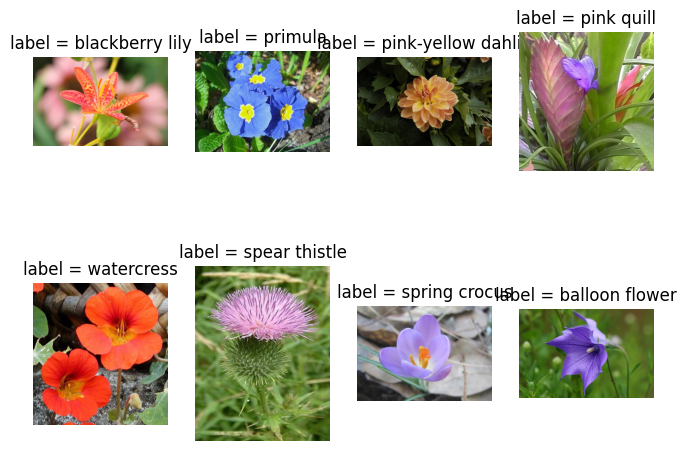

,image_path,image_label
0,D:/Documents/8vo Semestre/Sistemas Inteligente...,76
1,D:/Documents/8vo Semestre/Sistemas Inteligente...,76
2,D:/Documents/8vo Semestre/Sistemas Inteligente...,76
3,D:/Documents/8vo Semestre/Sistemas Inteligente...,76
4,D:/Documents/8vo Semestre/Sistemas Inteligente...,76
...,...,...
8184,D:/Documents/8vo Semestre/Sistemas Inteligente...,61
8185,D:/Documents/8vo Semestre/Sistemas Inteligente...,61
8186,D:/Documents/8vo Semestre/Sistemas Inteligente...,61
8187,D:/Documents/8vo Semestre/Sistemas Inteligente...,61


In [18]:
#sorted(os.listdir(data_path))[0]
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8,6))
image_num = random.sample(range(1,8190), 8)
for i in range(2):
  for j in range(4):
    image = skio.imread(os.path.join(data_path, f'image_{image_num[i*4+j]:05}.jpg'))
    ax[i,j].imshow(image)
    ax[i,j].axis('off')
    ax[i,j].set_title(f'label = {CLASSES[label_arr[0,image_num[i*4+j]]]}')
plt.show()

# data frame: index: 8189; columns: 'path', 'label
labels_list = list(label_arr[0, :])
image_path_list = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
metadata = pd.DataFrame(
    {'image_path': image_path_list,
     'image_label': labels_list}
)
metadata

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


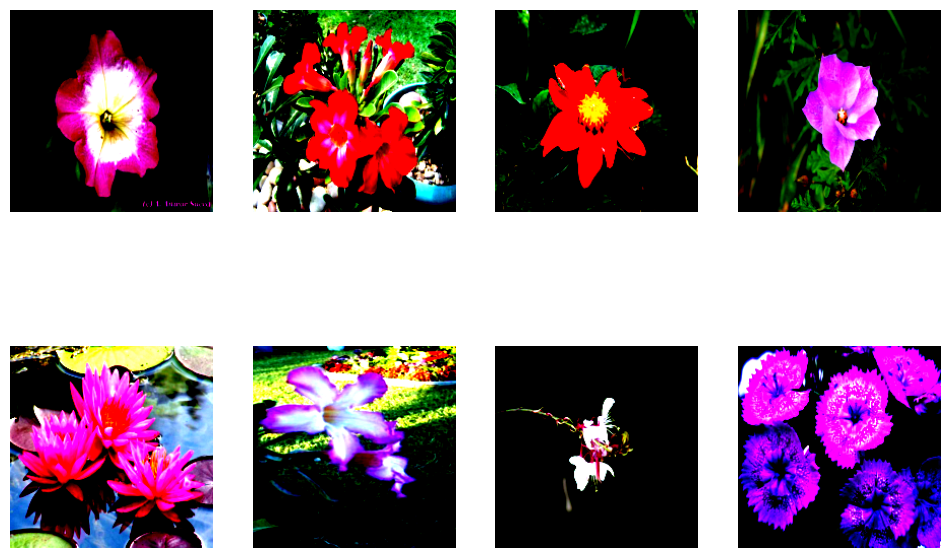

In [19]:
class MyFlowerDataset(Dataset):
  def __init__(self, metadata, transform=None):
    self.metadata = metadata
    self.transform = transform

  def __len__(self):
    return len(self.metadata)

  def __getitem__(self, idx):
    image_path = self.metadata.iloc[idx, 0]
    image = skio.imread(image_path)
    label = torch.tensor(int(metadata.iloc[idx, 1]))
    label = F.one_hot(label, num_classes=102)
    label = label.float()
    if self.transform:
      image = self.transform(image)

    return (image, label)

flower_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_W, IMAGE_H)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = MyFlowerDataset(metadata, transform = flower_transform)

# Splitting dataset into train and test
train_set, test_set = torch.utils.data.random_split(dataset, [6500, 1689])

# defining the dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

for x,y in train_loader:
  x = x.to(device)
  fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,8))
  for i in range(2):
    for j in range(4):
      ax[i,j].imshow(x[i*4+j].cpu().permute(1,2,0))
      ax[i,j].axis('off')
  break
plt.show()

Training

100%|██████████| 102/102 [02:06<00:00,  1.24s/batch, loss=3.46]


Epoch 0: loss: 393.3388671875
Accuracy: 499/1689: 29.54


100%|██████████| 102/102 [01:07<00:00,  1.52batch/s, loss=1.85]


Epoch 1: loss: 161.26690673828125
Accuracy: 679/1689: 40.20


100%|██████████| 102/102 [01:07<00:00,  1.52batch/s, loss=0.345]


Epoch 2: loss: 35.73320388793945
Accuracy: 665/1689: 39.37


100%|██████████| 102/102 [01:07<00:00,  1.50batch/s, loss=0.0356]


Epoch 3: loss: 6.735188961029053
Accuracy: 689/1689: 40.79


100%|██████████| 102/102 [01:05<00:00,  1.56batch/s, loss=0.0117] 


Epoch 4: loss: 1.6064720153808594
Accuracy: 715/1689: 42.33


100%|██████████| 102/102 [01:03<00:00,  1.61batch/s, loss=0.00475]


Epoch 5: loss: 0.8600795865058899
Accuracy: 721/1689: 42.69


100%|██████████| 102/102 [01:07<00:00,  1.52batch/s, loss=0.00296]


Epoch 6: loss: 0.9527587294578552
Accuracy: 718/1689: 42.51


100%|██████████| 102/102 [01:03<00:00,  1.62batch/s, loss=0.00207]


Epoch 7: loss: 0.5281490683555603
Accuracy: 727/1689: 43.04


100%|██████████| 102/102 [01:04<00:00,  1.59batch/s, loss=0.00132]


Epoch 8: loss: 0.8112476468086243
Accuracy: 721/1689: 42.69


100%|██████████| 102/102 [01:02<00:00,  1.63batch/s, loss=0.00228]


Epoch 9: loss: 0.7745590806007385
Accuracy: 734/1689: 43.46


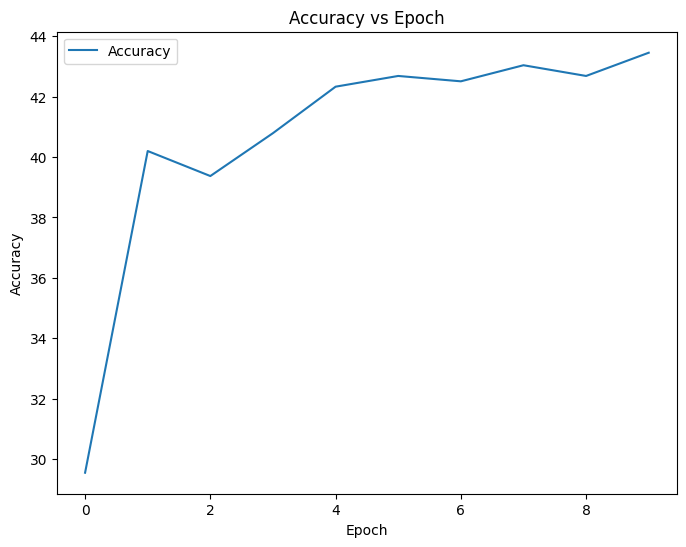

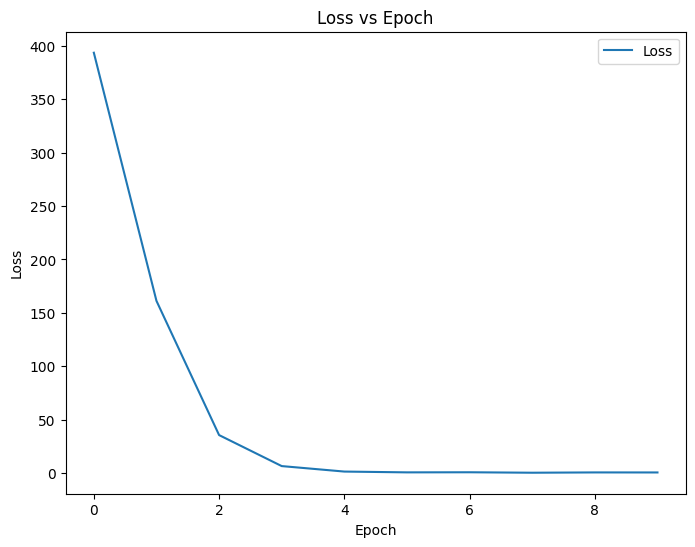

In [20]:
def check_accuracy(loader, model):
  num_corrects = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      # sending the data to the device
      x = x.to(device)
      y = y.to(device)

      # preparing the data for the model


      # forward
      y_hat = model(x)

      # calculate the accuracy
      _, labels = y.max(1)
      _, predictions = y_hat.max(1)
      num_corrects += (predictions == labels).sum()
      num_samples += predictions.size(0)

  print(f"Accuracy: {num_corrects}/{num_samples}: {num_corrects/num_samples*100:.2f}")
  model.train()
  return num_corrects, num_samples


epoch_list = []
accuracy_list = []
loss_list = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0
    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        for index, (x,y) in enumerate(tepoch):
            # send the data to the device
            x = x.to(device)
            y = y.to(device)

            # prepare the data

            # forward
            y_hat = model(x)
            loss = criterion(y_hat, y)
            running_loss += loss

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item())

        epoch_list.append(epoch)
        loss_list.append(running_loss.item())

        print(f"Epoch {epoch}: loss: {running_loss}")
        num_corrects, num_samples = check_accuracy(test_loader, model)

        # Calculate accuracy and append to lists
        accuracy = num_corrects / num_samples * 100
        accuracy_list.append(accuracy)

epoch_list = torch.tensor(epoch_list)
accuracy_list = torch.tensor(accuracy_list)
loss_list = torch.tensor(loss_list)

epoch_list = epoch_list.cpu().numpy()
accuracy_list = accuracy_list.cpu().numpy()
loss_list = loss_list.cpu().numpy()

torch.save(model.state_dict(), "models/my_model.pth")

# Plot accuracy vs epoch
plt.figure(figsize=(8, 6))
plt.plot(epoch_list, accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.savefig('figures/accuracy_vs_epoch.png')
plt.show()

# Plot loss vs epoch
plt.figure(figsize=(8, 6))
plt.plot(epoch_list, loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.savefig('figures/loss_vs_epoch.png')
plt.show()